In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor   #çok değişkenli aykırı değer yakalama
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import scipy.stats as stats

ModuleNotFoundError: No module named 'seaborn'

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [3]:

def load():
    """
    Load the TMDB movie data from various possible sources:
    1. Try GitHub raw data first
    2. Try local path next
    3. Finally, ask for manual upload in Colab
    """
    
    github_url = "https://raw.githubusercontent.com/busradoyran/tmdb_movie_analysis/main/data/tmdb_movies.csv"
    
    try:
        # Try loading from GitHub first
        data = pd.read_csv(github_url)
        print("Data loaded from GitHub successfully!")
    except:
        try:
            # Try loading from local path
            data = pd.read_csv("../data/tmdb_movies.csv")
            print("Data loaded from local path successfully!")
        except FileNotFoundError:
            # If running in Colab and previous methods failed, ask for upload
            try:
                from google.colab import files
                print("Please upload the tmdb_movies.csv file")
                uploaded = files.upload()
                data = pd.read_csv(next(iter(uploaded)))
                print("Data loaded from uploaded file successfully!")
            except:
                raise Exception("Could not load the data from any source. Please check the data file location.")
    
    return data

In [5]:
df = load()
df.head(10)

,title,release_date,rating,director,writer,genres,runtime,original_language,budget,revenue
0,"""Mitchell""!",10/09/1975 (US),32,Andrew V. McLaglen,Ian Kennedy Martin,"Suç,Dram,Aksiyon",1h 37m,İngilizce,-,-
1,*Piller Dahil Değildir,18/12/1987 (US),66,Matthew Robbins,NaN,"Aile,Komedi,Fantastik,Bilim-Kurgu",1h 46m,İngilizce,"$25,000,000.00","$65,088,797.00"
2,...Ve Tanrı Kadını Yarattı,28/11/1956 (FR),61,Roger Vadim,NaN,"Dram,Romantik",1h 32m,Fransızca,"$300,000.00","$33,000,000.00"
3,100 Kız,01/09/2000 (US),58,Michael Davis,Michael Davis,"Komedi,Dram,Romantik",1h 34m,İngilizce,-,-
4,101 Dalmaçyalı,25/01/1961 (US),72,Hamilton Luske,NaN,"Macera,Animasyon,Komedi,Aile",1h 19m,İngilizce,"$3,600,000.00","$303,000,000.00"
5,101 Dalmaçyalı 2: Patch'in Londra Macerası,21/01/2003 (US),60,Jim Kammerud,NaN,"Aile,Animasyon,Macera,Komedi",1h 14m,İngilizce,-,-
6,102 Dalmaçyalı,21/11/2000 (US),55,Kevin Lima,NaN,"Aile,Komedi",1h 40m,İngilizce,"$85,000,000.00","$183,611,771.00"
7,12 Days of Christmas,01/09/2020 (US),50,Michael Boyle,Michael Boyle,"Komedi,Dram,Romantik",1h 26m,İngilizce,"$30,000.00",-
8,12 Feet Deep,20/06/2017 (US),57,Matt Eskandari,Matt Eskandari,"Gerilim,Korku",1h 25m,İngilizce,-,"$6,158.00"
9,12 Yıllık Esaret,24/01/2014 (TR),79,Steve McQueen,NaN,"Dram,Tarih",2h 14m,İngilizce,"$20,000,000.00","$187,000,000.00"


In [6]:
def get_column_info(df, columns_of_interest):
    """
    Returns the number of unique classes and the count of each class
    for the specified columns in a DataFrame.

    """
    column_info = {}
    for col in columns_of_interest:
        nunique = df[col].nunique()
        value_counts = df[col].value_counts()
        column_info[col] = {
            "unique_value_count": nunique,
            "value_counts": value_counts.to_dict()
        }
    return column_info

In [7]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [8]:
missing_values_table(df, True)

          n_miss  ratio
writer      3715 58.220
director       7  0.110
genres         5  0.080


['director', 'writer', 'genres']

In [ ]:
def preprocess_data(df):

  '''DATA CLEANING'''

  # Create a copy to avoid SettingWithCopyWarning
  df = df.copy()

  # Remove duplicate header rows
  df = df[df['title'] != 'title']

    # Convert rating column to numeric
  df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
     
  # Removed $ signs and commas from 'budget' and 'revenue' columns.
  df['revenue'] = df['revenue'].str.replace('$', '').str.replace(',', '')
  df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

  df['budget'] = df['budget'].str.replace('$', '').str.replace(',', '')
  df['budget'] = pd.to_numeric(df['budget'], errors='coerce')



  '''TRANSFORMATION'''

  # Classes with very low frequency were grouped together under the label "Other".
  df['original_language'] = df['original_language'].apply(lambda x: x if x in
   ['İngilizce', 'Japonca', 'Fransızca', 'Korece', 'İtalyanca', 'Çince', 'İspanyolca','Almanca','Rusça'] else 'Other')

  # Processed the 'language' column using one-hot encoding.
  language_dummies = pd.get_dummies(df['original_language'], prefix='language')
  df = pd.concat([df, language_dummies], axis=1)
  # True/False değerlerini 0/1 olarak dönüştürme
  df[language_dummies.columns] = df[language_dummies.columns].astype(int)

  # Processed the 'genres' column using one-hot encoding.
  genres_dummies = df['genres'].str.get_dummies(sep=',')
  genres_dummies = genres_dummies.add_prefix('genres_')
  df = pd.concat([df, genres_dummies], axis=1)


  # Converted durations like '1h 41m' to total minutes (e.g., 101).
  def convert_runtime(runtime):
        if pd.isnull(runtime) or runtime == 'runtime':  # Handle 'runtime' string from duplicate header
            return 0
        h, m = 0, 0
        if 'h' in runtime:
            h = int(runtime.split('h')[0].strip())
        if 'm' in runtime:
            m = int(runtime.split('h')[1].split('m')[0].strip()) if 'h' in runtime else int(runtime.split('m')[0].strip())
        return h * 60 + m

  df['runtime'] = df['runtime'].apply(convert_runtime)



  '''FEATURE EXTRACTION'''

  # Created a new variable by extracting the year from the 'release_date' column.
  df['release_year'] = df['release_date'].apply(lambda x: int(x.split('/')[2].split()[0]) if pd.notnull(x) else 0)

  # Created a new variable indicating the release season based on the month in the 'release_date' column.
  def get_season(month):
      if month in [12, 1, 2]:
          return 'Winter'
      elif month in [3, 4, 5]:
          return 'Spring'
      elif month in [6, 7, 8]:
          return 'Summer'
      else:
          return 'Autumn'

  df['release_month'] = df['release_date'].apply(lambda x: int(x.split('/')[1]) if pd.notnull(x) else 0)
  df['release_season'] = df['release_month'].apply(get_season)
  df.drop(columns=['release_month'], inplace=True)

  # Applied one-hot encoding to the 'release_season' column.
  season_dummies = pd.get_dummies(df['release_season'], prefix='season')
  df = pd.concat([df, season_dummies], axis=1)


  # revenue - budget = net_gain
  df['net_gain'] = df.apply(lambda row: row['revenue'] - row['budget'] if pd.notnull(row['revenue']) and pd.notnull(row['budget']) else 0, axis=1)

  df_directors = df[df['director'] != 'Unknown']
  director_counts = df_directors['director'].value_counts().reset_index()

  director_counts.columns = ['director', 'film_count']
  director_ratings = df_directors.groupby('director')['rating'].mean().reset_index()
  director_ratings.columns = ['director', 'avg_rating']

  df = df.merge(director_counts, on='director', how='left')
  df = df.merge(director_ratings, on='director', how='left')
  df['film_count'] = df['film_count'].fillna(0).astype(int)

  # Dropped the columns that were one-hot encoded.
  df.drop(columns=['release_date', 'release_season', 'genres', 'original_language'], inplace=True)


  '''MISSING VALUES'''

  # Handling missing values in 'budget' and 'revenue' columns by filling them with the mean values.
  df['budget'] = df.groupby('director')['budget'].transform(lambda x: x.fillna(x.mean() if x.count() > 1 else df['budget'].mean()))
  df['revenue'] = df.groupby('director')['revenue'].transform(lambda x: x.fillna(x.mean() if x.count() > 1 else df['revenue'].mean()))

  # Removed movies with missing director or missing title.
  df = df.dropna(subset=['director'])
  df = df.dropna(subset=['title'])

  '''NORMALIZATION'''
  features = ['release_year', 'runtime', 'budget', 'revenue', 'net_gain', 'film_count', 'avg_rating'] + \
               [col for col in df.columns if col.startswith('language_') or col.startswith('genres_') or col.startswith('season_')]

  X = df[features]  # Fill remaining NaN values with 0.


  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  return df, X_scaled, scaler


In [ ]:
def cluster_movies(X_scaled):
    # Grouped the movies using K-means clustering.
    kmeans = KMeans(n_clusters=5, random_state=42)
    movie_clusters = kmeans.fit_predict(X_scaled)
    return movie_clusters

In [11]:
def cluster_directors(df):
    director_features = ['film_count', 'budget', 'revenue', 'net_gain'] + \
                        [col for col in df.columns if col.startswith('genres_')]

    # Calculated the average values per director.
    X_directors = df.groupby('director')[director_features].mean().reset_index()

    # Normalized the features per director.
    scaler = StandardScaler()
    X_directors_scaled = scaler.fit_transform(X_directors[director_features])

    # Clustered the directors using K-means.
    kmeans_directors = KMeans(n_clusters=5, random_state=42)
    X_directors['director_cluster'] = kmeans_directors.fit_predict(X_directors_scaled)

    return X_directors

In [12]:
'''VISUALIZATION'''

def visualize_clusters(df, movie_clusters):
    # Film kümelerini görselleştirme
    df['movie_cluster'] = movie_clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x=df['budget'], y=df['revenue'], c=df['movie_cluster'], cmap='viridis')
    plt.xlabel('Budget')
    plt.ylabel('Revenue')
    plt.title('Film Kümeleri')
    plt.colorbar(scatter)
    plt.show()
    print("######################################")

def visualize_boxplot(df):
    # Film kümelerine göre rating dağılımı
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='movie_cluster', y='rating', data=df)
    plt.xlabel('Film Kümesi')
    plt.ylabel('Rating')
    plt.title('Film Kümelerine Göre Rating Dağılımı')
    plt.show()
    print("######################################")

    # Calculated the proportions of genres.
    genre_cols = [col for col in df.columns if col.startswith('genres_')]
    clusters = df['movie_cluster'].unique()

    genre_ratios = {}
    for cluster in clusters:
        cluster_data = df[df['movie_cluster'] == cluster]
        total_count = cluster_data.shape[0]
        genre_ratios[cluster] = (cluster_data[genre_cols].sum() / total_count * 100).sort_values(ascending=False)

    # Visualized the proportions as a table.
    genre_ratios_df = pd.DataFrame(genre_ratios).fillna(0).T
    genre_ratios_df = genre_ratios_df.round(2)  # Rounded the proportions.
    display(genre_ratios_df)

    return genre_ratios_df



def visualize_top_directors(df):
    # Selected the numerical columns.
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    # Visualized the top 10 directors with the highest average ratings.
    top_directors = df.groupby('director')[numeric_cols].mean().sort_values(by='avg_rating', ascending=False).head(10)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_directors.index, y=top_directors['avg_rating'])
    plt.xlabel('Director')
    plt.ylabel('Average Rating')
    plt.title('Top 10 Directors by Average Rating')
    plt.xticks(rotation=45)
    plt.show()
    print("######################################")

In [13]:
# Examined the extent to which each cluster contains different genres.

def visualize_genres_in_clusters(df):
    # Calculated the totals for clusters and genres.
    genre_cols = [col for col in df.columns if col.startswith('genres_')]
    clusters = df['movie_cluster'].unique()

    # Calculated the count of each genre for every cluster.
    genre_distributions = {}
    for cluster in clusters:
        cluster_data = df[df['movie_cluster'] == cluster]
        genre_sums = cluster_data[genre_cols].sum().sort_values(ascending=False)
        genre_distributions[cluster] = genre_sums

    # Visualization
    fig, axes = plt.subplots(nrows=len(clusters), ncols=1, figsize=(12, 8 * len(clusters)))

    if len(clusters) == 1:
        axes = [axes]

    for i, cluster in enumerate(clusters):
        sns.barplot(x=genre_distributions[cluster].index.str.replace('genres_', ''), y=genre_distributions[cluster].values, ax=axes[i])
        axes[i].set_title(f'Cluster {cluster} - Genre Distribution')
        axes[i].set_xlabel('Genre')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [14]:
def train_model(df):

    # Preparing the data to train the model.
    features = ['release_year', 'runtime', 'budget', 'revenue', 'net_gain', 'film_count'] + \
               [col for col in df.columns if col.startswith('language_') or col.startswith('genres_') or col.startswith('season_')]
    X = df[features]
    y = df['rating']

    # Splitting the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Training the Linear Regression model.
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluating the model's performance.
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Squared Error: {mse}")

    return model, X_test, y_test, y_pred

In [15]:
def evaluate_model_performance(y_test, y_pred):
    # Visualizing Actual vs Predicted Values: The red dashed line represents the perfect prediction line (residuals = actual values = predicted values).
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, y_pred)
    plt.xlabel('Gerçek Ratingler')
    plt.ylabel('Tahmin Edilen Ratingler')
    plt.title('Gerçek vs Tahmin Edilen Ratingler')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.show()

    # Visualizing the residuals (Residual Plot).
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 8))
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Tahmin Edilen Ratingler')
    plt.ylabel('Artıklar')
    plt.title('Residual Plot')
    plt.show()

    # Histogram of residuals.
    plt.figure(figsize=(10, 8))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Artıklar')
    plt.title('Histogram of Residuals')
    plt.show()

    # QQ Plot: Assessed how well the residuals follow a normal distribution.
    plt.figure(figsize=(10, 8))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')
    plt.show()

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_genre_ratings_by_season(df):
    # Calculated the average rating and the number of movies for each season.
    seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
    genre_columns = [col for col in df.columns if col.startswith('genres_')]

    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Mevsimlere Göre Türlerin Ortalama Rating ve Film Sayıları')

    for i, season in enumerate(seasons):
        row = i // 2
        col = i % 2
        season_df = df[df[f'season_{season}'] == 1]

        genre_ratings = season_df[genre_columns + ['rating']].copy()
        genre_stats = []

        for genre in genre_columns:
            genre_name = genre.replace('genres_', '')
            avg_rating = genre_ratings[genre_ratings[genre] == 1]['rating'].mean()
            film_count = genre_ratings[genre_ratings[genre] == 1].shape[0]
            genre_stats.append({'genre': genre_name, 'avg_rating': avg_rating, 'film_count': film_count})

        genre_stats_df = pd.DataFrame(genre_stats).dropna().sort_values(by='avg_rating', ascending=False)

        ax = axs[row, col]
        sns.barplot(x='avg_rating', y='genre', data=genre_stats_df, ax=ax, palette="Blues_d", dodge=False, legend=False)
        ax.set_title(f'{season} - Genre Ratings')
        ax.set_xlabel('Ortalama Rating')
        ax.set_xlim(0, 100)

        # Added the movie counts next to the bars.
        for index, row in genre_stats_df.iterrows():
            ax.text(row['avg_rating'] + 2, index, f'({int(row["film_count"])} film)', color='black', ha="left")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

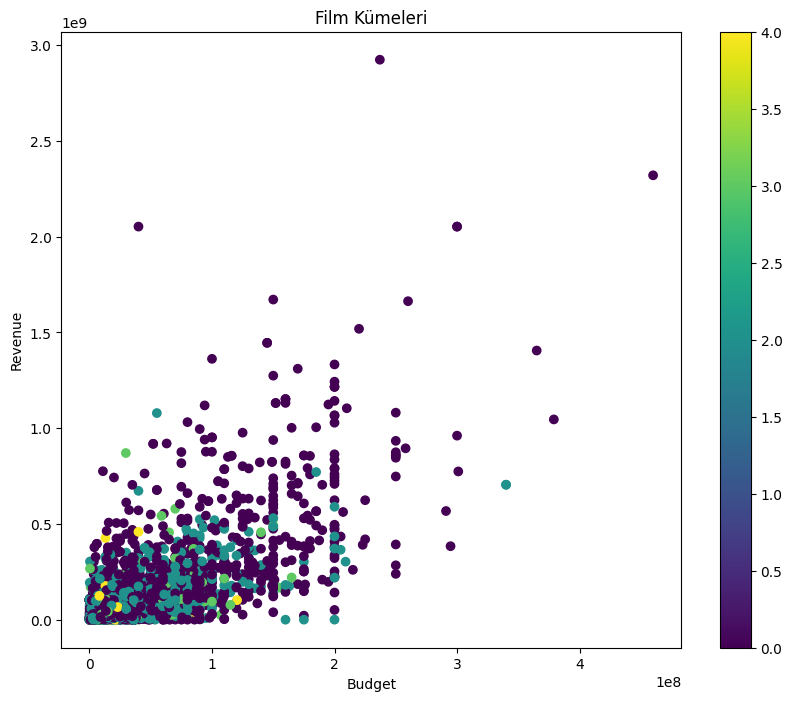

######################################


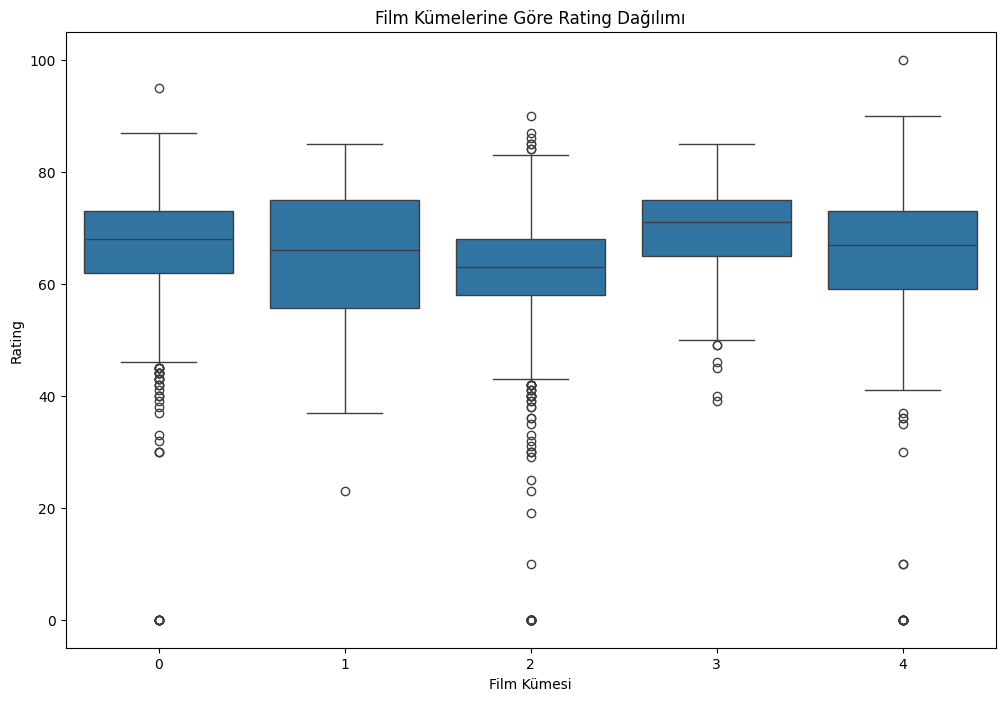

######################################


,genres_Aile,genres_Aksiyon,genres_Animasyon,genres_Belgesel,genres_Bilim-Kurgu,genres_Dram,genres_Fantastik,genres_Gerilim,genres_Gizem,genres_Komedi,genres_Korku,genres_Macera,genres_Müzik,genres_Romantik,genres_Savaş,genres_Suç,genres_TV film,genres_Tarih,genres_Vahşi Batı
2,0.090,35.040,0.990,0.170,15.540,34.860,4.340,64.360,20.520,10.690,36.070,7.690,0.040,3.090,0.000,31.560,1.250,1.330,0.690
0,23.840,21.450,21.600,1.910,13.040,42.180,20.520,1.380,1.680,45.920,1.410,28.120,4.910,23.990,0.000,2.930,2.060,5.410,2.720
4,6.630,22.930,5.520,1.930,6.350,56.910,9.940,22.100,7.180,27.070,7.460,12.710,0.830,31.490,0.000,13.540,0.280,6.080,0.280
3,0.420,44.170,1.670,0.420,3.330,68.750,2.920,16.250,1.250,7.920,1.670,19.170,0.830,9.170,100.000,0.830,0.830,33.330,0.830
1,1.000,12.000,0.000,1.000,6.000,55.000,8.000,16.000,7.000,29.000,23.000,9.000,0.000,19.000,6.000,13.000,1.000,5.000,10.000


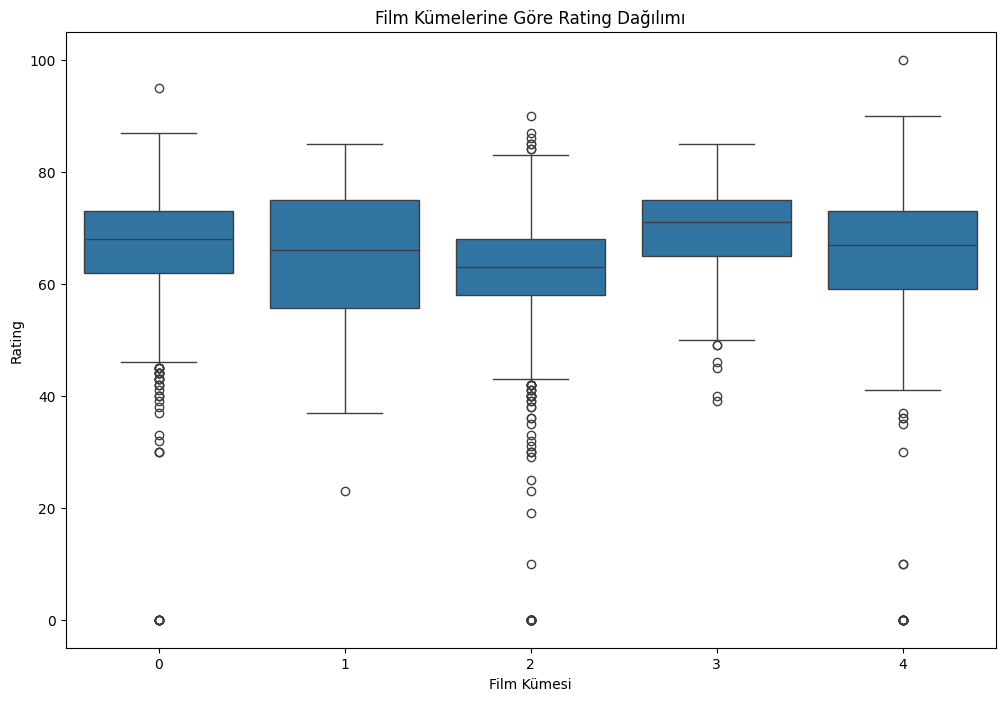

######################################


,genres_Aile,genres_Aksiyon,genres_Animasyon,genres_Belgesel,genres_Bilim-Kurgu,genres_Dram,genres_Fantastik,genres_Gerilim,genres_Gizem,genres_Komedi,genres_Korku,genres_Macera,genres_Müzik,genres_Romantik,genres_Savaş,genres_Suç,genres_TV film,genres_Tarih,genres_Vahşi Batı
2,0.090,35.040,0.990,0.170,15.540,34.860,4.340,64.360,20.520,10.690,36.070,7.690,0.040,3.090,0.000,31.560,1.250,1.330,0.690
0,23.840,21.450,21.600,1.910,13.040,42.180,20.520,1.380,1.680,45.920,1.410,28.120,4.910,23.990,0.000,2.930,2.060,5.410,2.720
4,6.630,22.930,5.520,1.930,6.350,56.910,9.940,22.100,7.180,27.070,7.460,12.710,0.830,31.490,0.000,13.540,0.280,6.080,0.280
3,0.420,44.170,1.670,0.420,3.330,68.750,2.920,16.250,1.250,7.920,1.670,19.170,0.830,9.170,100.000,0.830,0.830,33.330,0.830
1,1.000,12.000,0.000,1.000,6.000,55.000,8.000,16.000,7.000,29.000,23.000,9.000,0.000,19.000,6.000,13.000,1.000,5.000,10.000


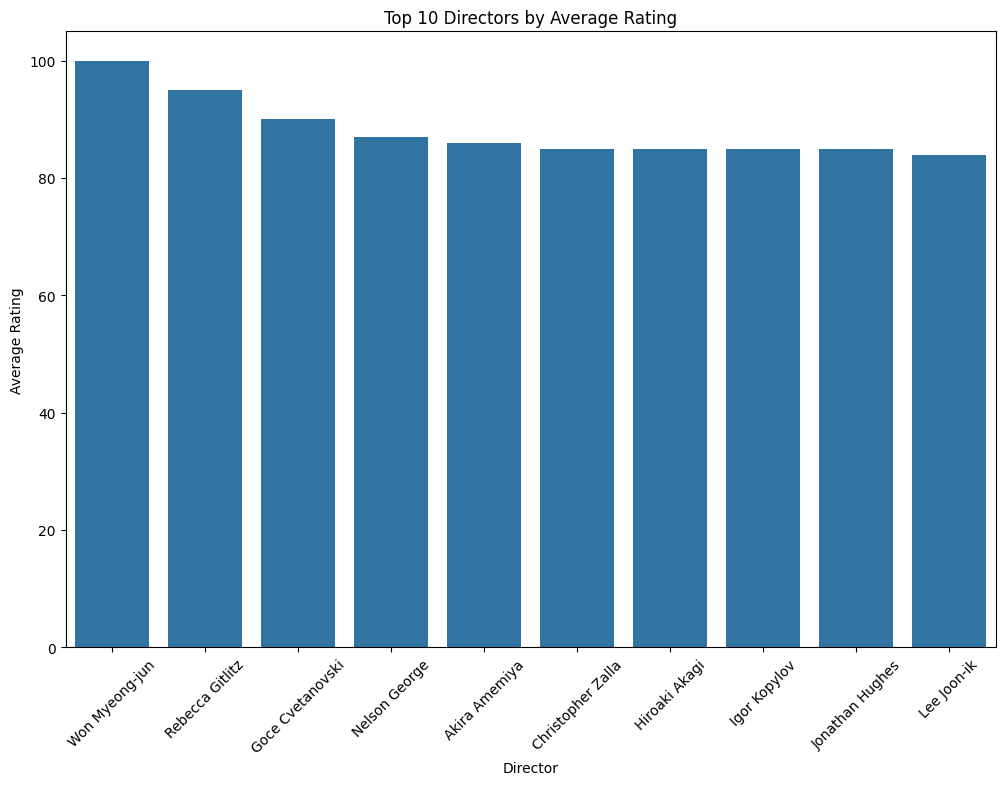

######################################


/tmp/ipython-input-16-1046529572.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='genre', data=genre_stats_df, ax=ax, palette="Blues_d", dodge=False, legend=False)
/tmp/ipython-input-16-1046529572.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='genre', data=genre_stats_df, ax=ax, palette="Blues_d", dodge=False, legend=False)
/tmp/ipython-input-16-1046529572.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='genre', data=genre_stats_df, ax=ax, palette="Blues_d", dodge=False, 

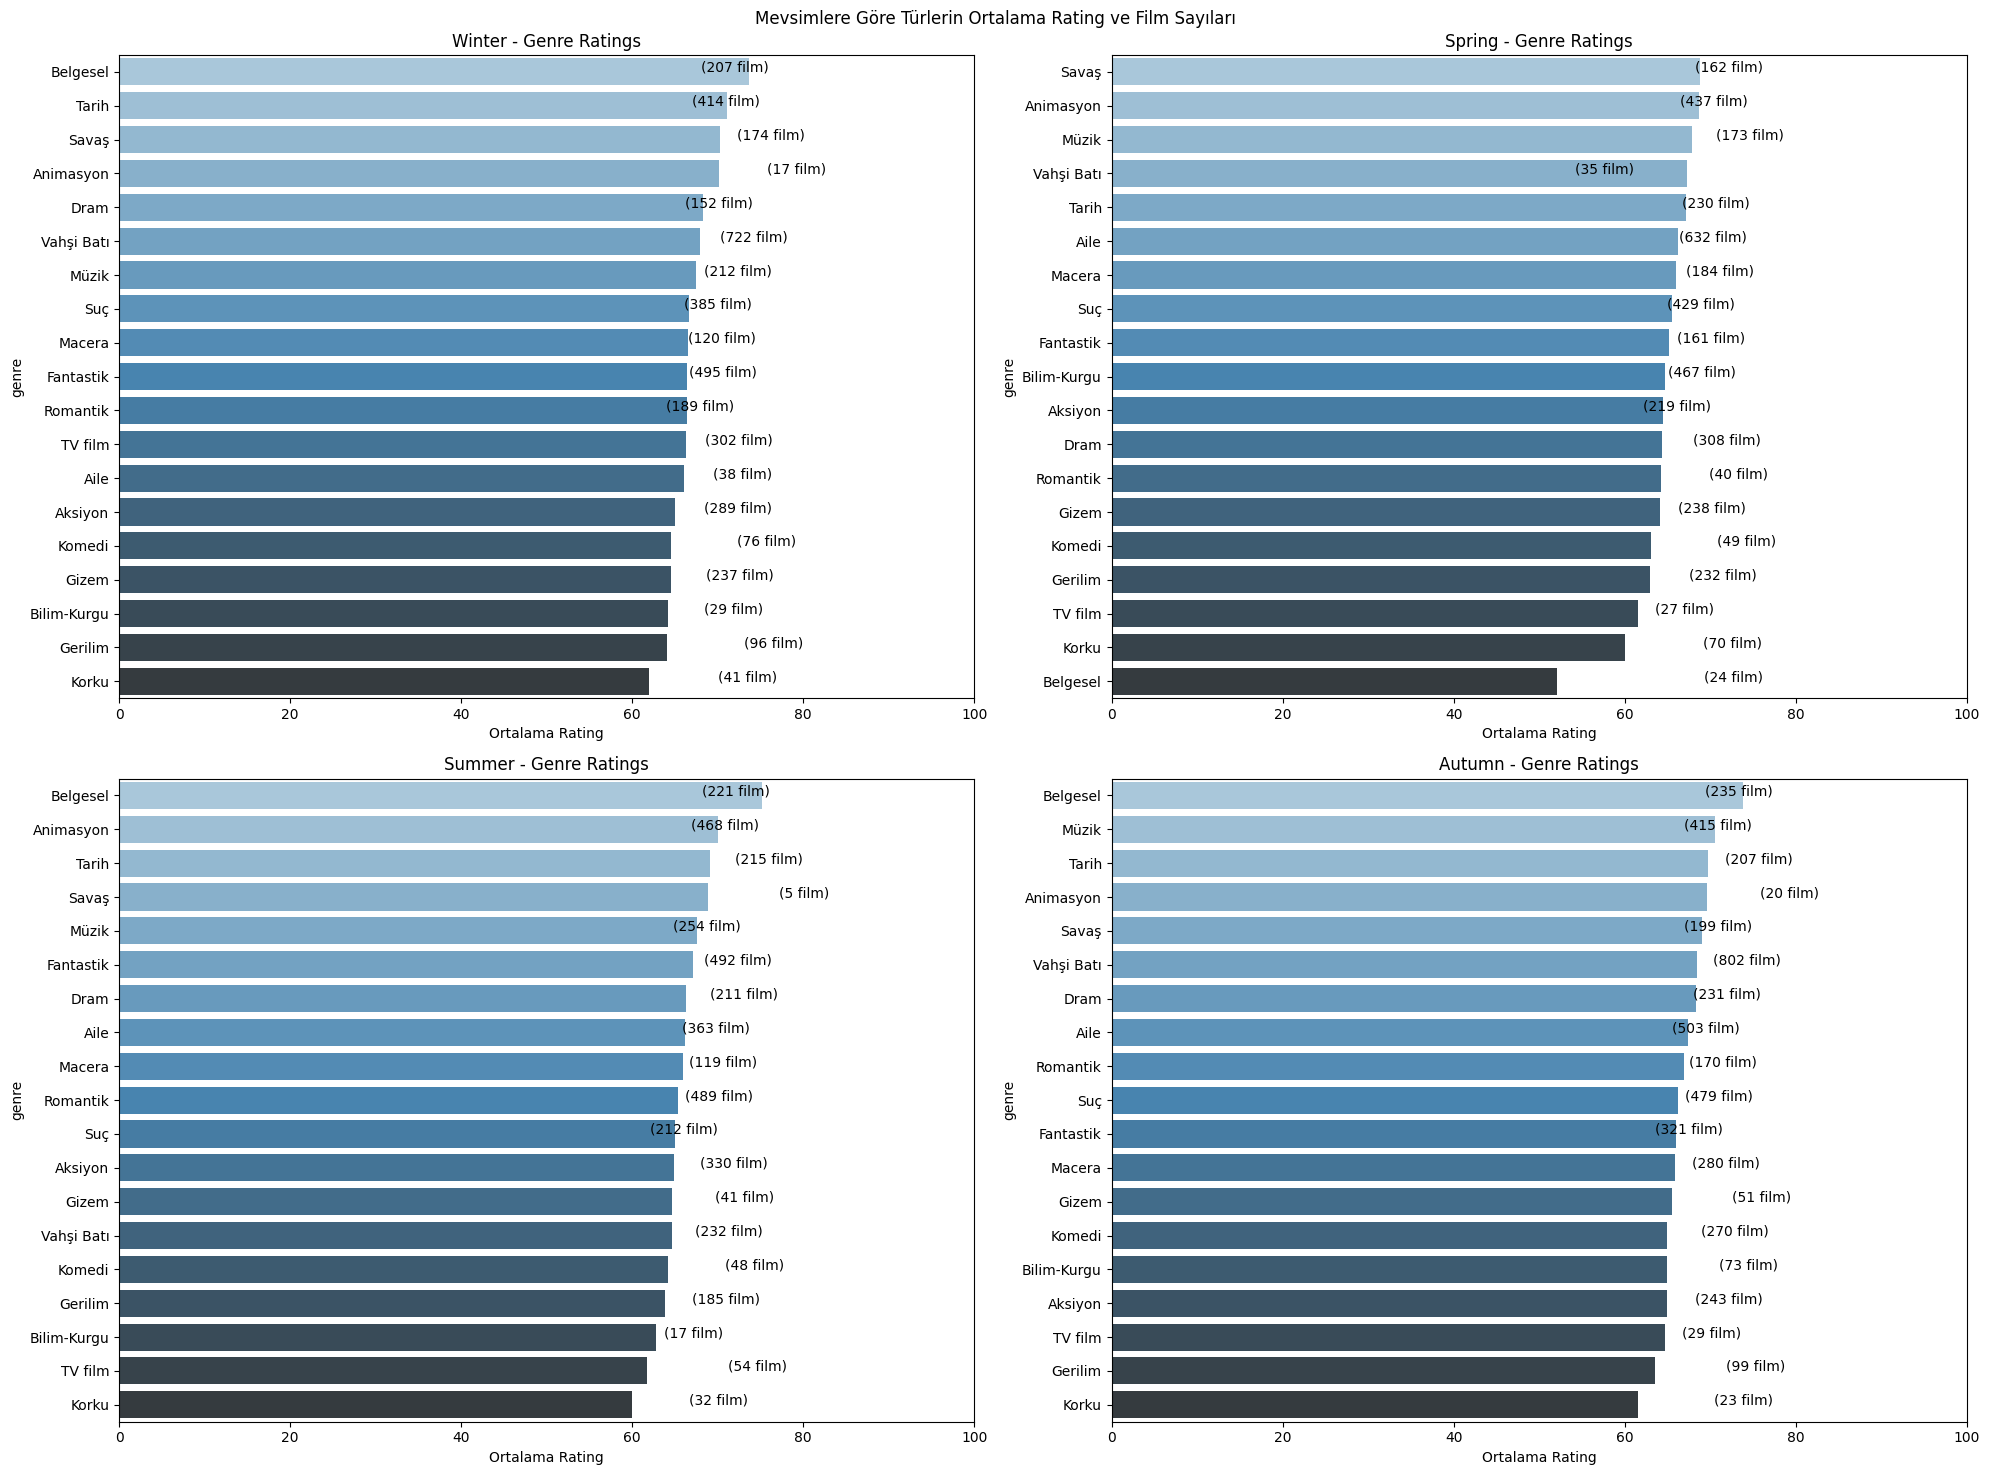

Root Mean Squared Error: 10.370504466672756
Mean Squared Error: 107.5473628932796


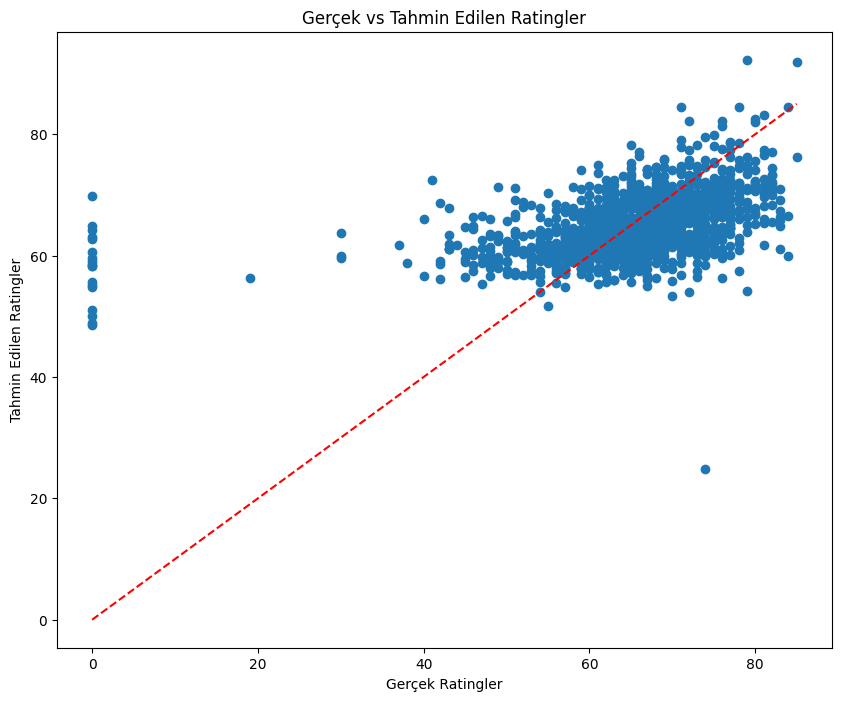

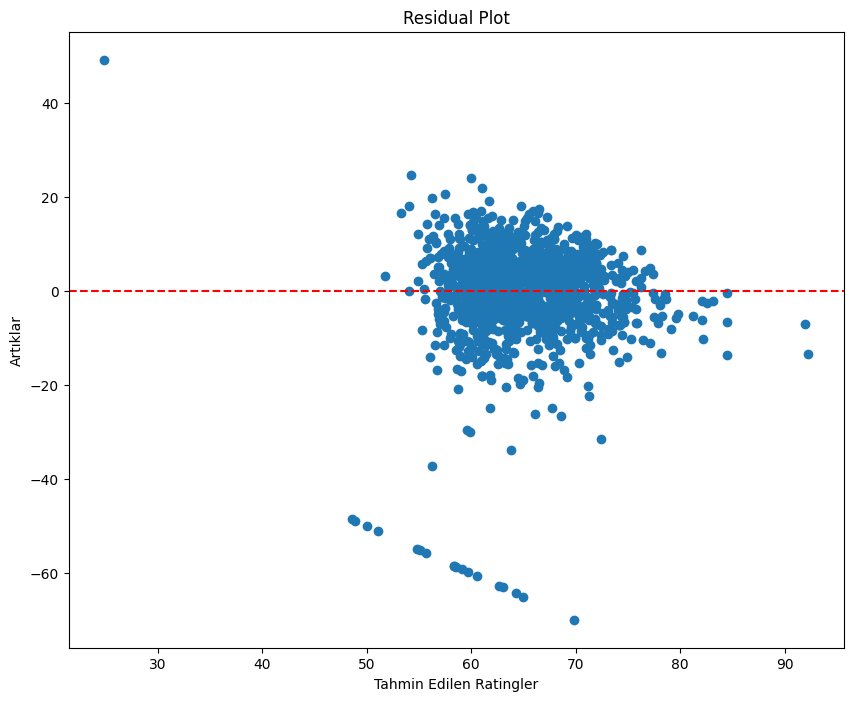

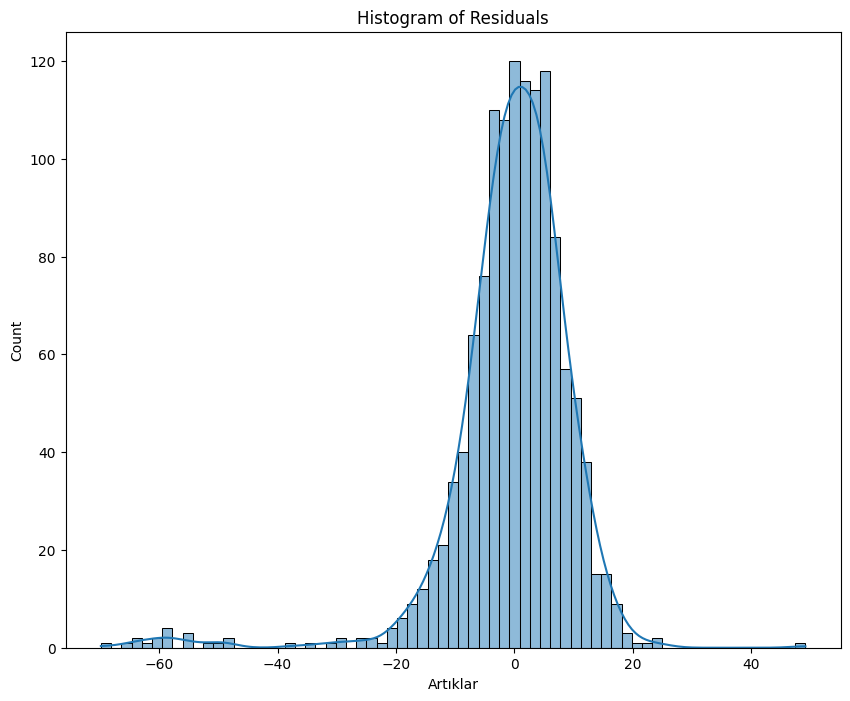

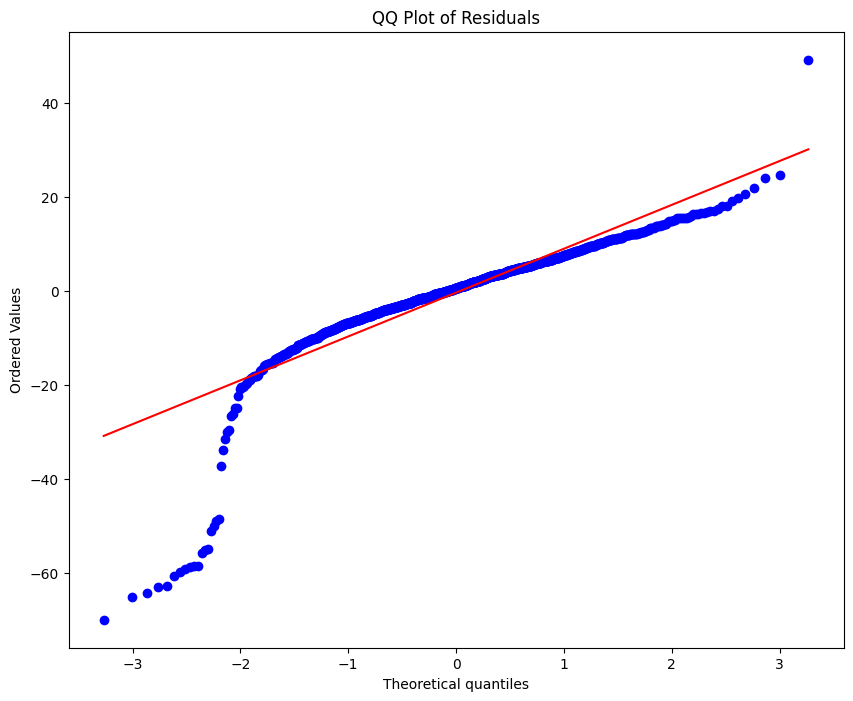

In [17]:
df = load()
df, X_scaled, scaler = preprocess_data(df)

# Grouped the movies into clusters.
movie_clusters = cluster_movies(X_scaled)

# Grouped the directors into clusters.
director_clusters = cluster_directors(df)

'''Visualization'''

visualize_clusters(df, movie_clusters)
visualize_boxplot(df)
genre_ratios_df = visualize_boxplot(df)
visualize_top_directors(df)

# Average ratings of movie genres by season.
visualize_genre_ratings_by_season(df)


'''Model'''

model, X_test, y_test, y_pred = train_model(df)

features = ['release_year', 'runtime', 'budget', 'revenue', 'net_gain'] + \
           [col for col in df.columns if col.startswith('language_') or col.startswith('genres_') or col.startswith('release_season_')]

evaluate_model_performance(y_test, y_pred)

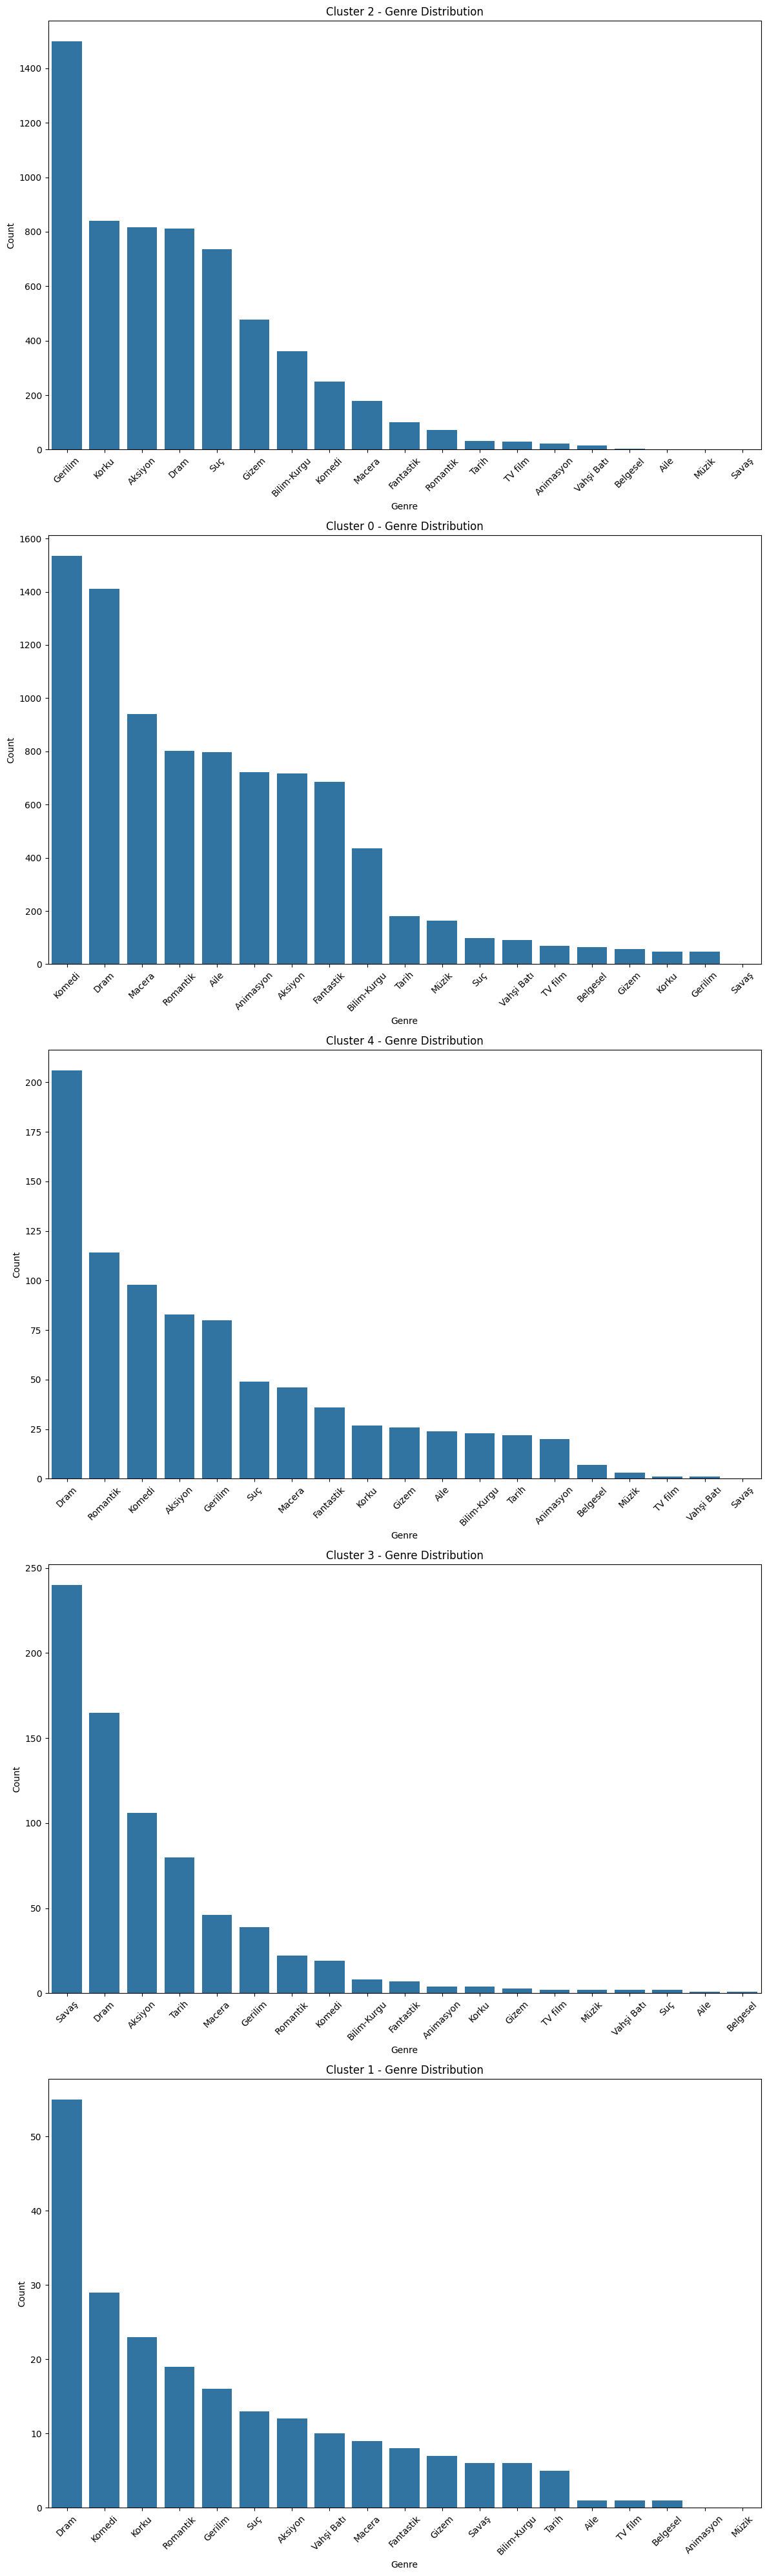

In [18]:
visualize_genres_in_clusters(df)

In [19]:
df.head(20)

,title,rating,director,writer,runtime,budget,revenue,language_Almanca,language_Fransızca,language_Japonca,language_Korece,language_Other,language_Rusça,language_Çince,language_İngilizce,language_İtalyanca,genres_Aile,genres_Aksiyon,genres_Animasyon,genres_Belgesel,genres_Bilim-Kurgu,genres_Dram,genres_Fantastik,genres_Gerilim,genres_Gizem,genres_Komedi,genres_Korku,genres_Macera,genres_Müzik,genres_Romantik,genres_Savaş,genres_Suç,genres_TV film,genres_Tarih,genres_Vahşi Batı,release_year,season_Autumn,season_Spring,season_Summer,season_Winter,net_gain,film_count,avg_rating,movie_cluster
0,"""Mitchell""!",32,Andrew V. McLaglen,Ian Kennedy Martin,97,36219227.982,102249103.899,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1975,True,False,False,False,0.000,5,56.400,2
1,*Piller Dahil Değildir,66,Matthew Robbins,NaN,106,25000000.000,65088797.000,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1987,False,False,False,True,40088797.000,2,65.000,0
2,...Ve Tanrı Kadını Yarattı,61,Roger Vadim,NaN,92,300000.000,33000000.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1956,True,False,False,False,32700000.000,1,61.000,4
3,100 Kız,58,Michael Davis,Michael Davis,94,36219227.982,102249103.899,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,2000,True,False,False,False,0.000,2,61.500,0
4,101 Dalmaçyalı,72,Hamilton Luske,NaN,79,3600000.000,303000000.000,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1961,False,False,False,True,299400000.000,3,67.333,0
5,101 Dalmaçyalı 2: Patch'in Londra Macerası,60,Jim Kammerud,NaN,74,36219227.982,102249103.899,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,2003,False,False,False,True,0.000,1,60.000,0
6,102 Dalmaçyalı,55,Kevin Lima,NaN,100,85000000.000,183611771.000,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2000,True,False,False,False,98611771.000,3,64.333,0
7,12 Days of Christmas,50,Michael Boyle,Michael Boyle,86,30000.000,102249103.899,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,2020,True,False,False,False,0.000,1,50.000,0
8,12 Feet Deep,57,Matt Eskandari,Matt Eskandari,85,36219227.982,6158.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2017,False,False,True,False,0.000,3,56.667,2
9,12 Yıllık Esaret,79,Steve McQueen,NaN,134,20000000.000,187000000.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2014,False,False,False,True,167000000.000,3,71.000,0
